In [22]:
import numpy as np
import cv2
import matplotlib
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
face_cascade = cv2.CascadeClassifier("opencv/haarcascades\haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("opencv/haarcascades\haarcascade_eye.xml")

In [3]:
def get_cropped_image_for_2_eyes(image_path):
    img_main = cv2.imread(image_path)
    if img_main is None:
        print('Not an image')
    else:
        try:
            gray_img = cv2.cvtColor(img_main, cv2.COLOR_BGR2GRAY)
        except UnboundLocalError:
            print('Gray image is not available')
            return None
        else:
            faces_gray = face_cascade.detectMultiScale(gray_img, 1.1, 5)
            for (x,y,w,h) in faces_gray:
                roi_color = img_main[y:y+h, x:x+w]
                eyes_gray = eye_cascade.detectMultiScale(gray_img, 1.1, 5)
                if len(eyes_gray) >=2:
                    return roi_color

this function will return only one image. because if u have 2 faces in your image after returning first roi color the loop will stop

In [4]:
path_to_data = "./Datasets/"
path_to_cr_data = "./Datasets/cropped/"

In [5]:
import os
player_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        player_dirs.append(entry.path)

In [6]:
player_dirs

['./Datasets/lewandski',
 './Datasets/luca_modric',
 './Datasets/messi',
 './Datasets/neymar',
 './Datasets/ronaldo']

In [7]:
import shutil

if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [8]:
cropped_img_dirs = []
player_name_file = {}

for dirs in player_dirs:

    count = 1
    player_name = dirs.split('/')[-1]
    player_name_file[player_name] = []

    for image in os.scandir(dirs):

        roi_color = get_cropped_image_for_2_eyes(image.path)

        if roi_color is not None:
            cropped_folder = path_to_cr_data + player_name

            if not os.path.exists(cropped_folder):
                print('Generating cropped images in folder', cropped_folder)
                os.mkdir(cropped_folder)

            cropped_img_dirs.append(cropped_folder)

            cropped_file_name = player_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            player_name_file[player_name].append(cropped_file_path)
            count += 1


Generating cropped images in folder ./Datasets/cropped/lewandski
Not an image
Generating cropped images in folder ./Datasets/cropped/luca_modric
Not an image
Not an image
Generating cropped images in folder ./Datasets/cropped/messi
Generating cropped images in folder ./Datasets/cropped/neymar
Not an image
Generating cropped images in folder ./Datasets/cropped/ronaldo


In [10]:
player_name_file

{'lewandski': ['./Datasets/cropped/lewandski/lewandski1.png',
  './Datasets/cropped/lewandski/lewandski2.png',
  './Datasets/cropped/lewandski/lewandski3.png',
  './Datasets/cropped/lewandski/lewandski4.png',
  './Datasets/cropped/lewandski/lewandski5.png',
  './Datasets/cropped/lewandski/lewandski6.png',
  './Datasets/cropped/lewandski/lewandski7.png',
  './Datasets/cropped/lewandski/lewandski8.png',
  './Datasets/cropped/lewandski/lewandski9.png',
  './Datasets/cropped/lewandski/lewandski10.png',
  './Datasets/cropped/lewandski/lewandski11.png',
  './Datasets/cropped/lewandski/lewandski12.png',
  './Datasets/cropped/lewandski/lewandski13.png',
  './Datasets/cropped/lewandski/lewandski14.png',
  './Datasets/cropped/lewandski/lewandski15.png',
  './Datasets/cropped/lewandski/lewandski16.png',
  './Datasets/cropped/lewandski/lewandski17.png',
  './Datasets/cropped/lewandski/lewandski18.png',
  './Datasets/cropped/lewandski/lewandski19.png',
  './Datasets/cropped/lewandski/lewandski20.pn

Making a function to perform wavelet transformation which will give a feature image

In [11]:
import pywt
# I got this function from stack overflow
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

Making X and Y feature for my model training

In [13]:
player_number = {}
count = 0
for aplayer in player_name_file.keys():
    player_number[aplayer] = count
    count += 1
player_number

{'lewandski': 0, 'luca_modric': 1, 'messi': 2, 'neymar': 3, 'ronaldo': 4}

In [24]:
X = []
Y = []

for player, png_img in player_name_file.items():
    for png in png_img:
        img = cv2.imread(png) #reading the image
        if img is None: # Since I've deleted some images there will be error without this if statement
            continue
        scalled_img = cv2.resize(img, (32, 32)) #just to be safe with size issue i'm resizing this images
        wavelet_img = w2d(img, 'db1', 5 )
        scalled_wavelet_img = cv2.resize(wavelet_img, (32, 32)) # I need wavelet image in same size as the scalled image

        combined_image = np.vstack((scalled_img.reshape(32*32*3,1), scalled_wavelet_img.reshape(32*32,1))) # I'm stacking those images vertically because I'll use both of them as input 

        X.append(combined_image) # these are the input features
        Y.append(player_number[player]) # I need numbers for each player name to make an valid output for my model

In [28]:
len(X[0])

4096

In [30]:
X = np.array(X).reshape(len(X),4096).astype('float')
X.shape

(81, 4096)

In [31]:
X[0]

array([ 34.,  39.,  73., ...,  67., 176., 180.])

Creating the model

In [99]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

In [94]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', SVC(kernel='linear', C=10))])
pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)

0.8823529411764706

In [98]:
cross_val_score(pipe, x_train, y_train).mean()

0.5166666666666667

In [39]:
print(classification_report(y_test, pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      0.75      0.86         4

    accuracy                           0.88        17
   macro avg       0.87      0.85      0.82        17
weighted avg       0.92      0.88      0.88        17



SVM was a test model. now I'll find the best model using gridsearch

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [109]:
model_params = {
    'svm': {
        'model': SVC(kernel='linear'),
        'params' : {
            'svm__C': [1,10,100,1000],
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'random_forest__n_estimators': [10,40,50]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(),
        'params': {
            'logistic_regression__C': [1,5,10]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'decision_tree__criterion': ['gini','entropy'],
            
        }
    } 
}

In [110]:
import pandas as pd

cvgrd = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe2 = Pipeline([('scaler', StandardScaler()),(algo, mp['model'])]) # here the pipeline method is name sensitive.. look at the dictionary
    clf =  GridSearchCV(pipe2, mp['params'], cv=cvgrd, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.553846,{'svm__C': 1}
1,random_forest,0.461538,{'random_forest__n_estimators': 50}
2,logistic_regression,0.584615,{'logistic_regression__C': 1}
3,naive_bayes_gaussian,0.369231,{}
4,decision_tree,0.338462,{'decision_tree__criterion': 'gini'}


In [92]:
best_estimators['svm'].score(x_test,y_test)

0.8823529411764706

In [104]:
best_estimators['random_forest'].score(x_test,y_test)

0.6470588235294118

In [93]:
best_estimators['logistic_regression'].score(x_test,y_test)

0.8823529411764706

Here the winner is Logistic regression and svm. So I can use any of them. I'll go with svm

In [112]:
from sklearn.metrics import confusion_matrix

best_clf = best_estimators['svm']
cm = confusion_matrix(y_test, best_clf.predict(x_test))

Text(95.72222222222221, 0.5, 'Truth')

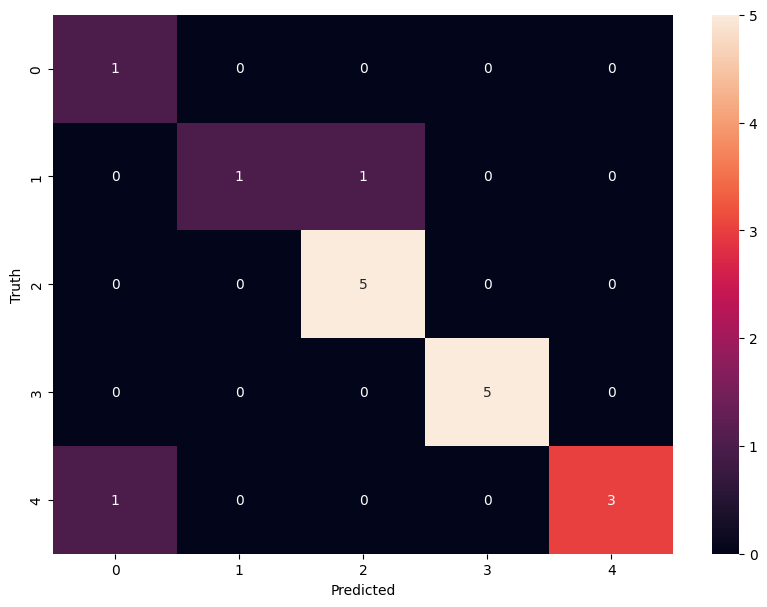

In [113]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [114]:
import joblib
joblib.dump(best_clf, 'model.pkl')

['model.pkl']

In [115]:
import json
with open("player_dictionary.json","w") as f:
    f.write(json.dumps(player_number))